<a href="https://colab.research.google.com/github/ngcheeyuan/Classification_projects/blob/main/Wine_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cheeyuanng","key":"70085cb366ad542072c5a36ba0e09e27"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d yasserh/wine-quality-dataset

  0% 0.00/21.5k [00:00<?, ?B/s]
100% 21.5k/21.5k [00:00<00:00, 8.37MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!unzip 'wine-quality-dataset.zip'

Archive:  wine-quality-dataset.zip
  inflating: WineQT.csv              


In [ ]:
df = pd.read_csv('WineQT.csv')
df.drop(columns = ['Id'] , axis = 'columns' , inplace = True)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = df.quality
X = df.drop(['quality'] , axis = 'columns')

## Splitting data before exploration

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size = 0.6, random_state = 42, stratify = y)

In [ ]:
X_val , X_test , y_val , y_test = train_test_split(X_val,y_val,
                                                   train_size = 0.5 ,
                                                   random_state = 42,
                                                   stratify = y_val)

In [ ]:
y_val.value_counts()  ,y_test.value_counts() , y_train.value_counts()

(5    97
 6    93
 7    28
 4     6
 8     4
 3     1
 Name: quality, dtype: int64, 5    97
 6    92
 7    29
 4     7
 8     3
 3     1
 Name: quality, dtype: int64, 5    289
 6    277
 7     86
 4     20
 8      9
 3      4
 Name: quality, dtype: int64)

## Base model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf1 = LogisticRegression(class_weight = 'balanced' , 
                         max_iter = 10000 , 
                         tol = 0.0001,
                         solver ='liblinear')

In [ ]:
clf1.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, solver='liblinear')

In [ ]:
clf1.score(X_train,y_train)

0.5080291970802919

In [ ]:
clf1.score(X_val,y_val)

0.5327510917030568

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
predictions = clf1.predict(X_val)

In [ ]:
cm = confusion_matrix(y_true = y_val,
                      y_pred = predictions)

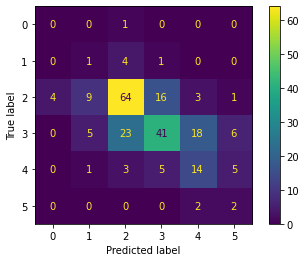

In [ ]:
ConfusionMatrixDisplay(cm).plot()

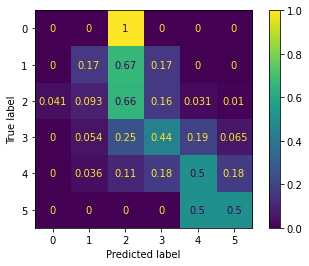

In [ ]:
cm_2 = confusion_matrix(y_true = y_val,
                        y_pred = predictions,normalize = 'true')
ConfusionMatrixDisplay(cm_2).plot()

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import make_column_selector , make_column_transformer

In [ ]:
ct = make_column_transformer((RobustScaler(),
                              make_column_selector(dtype_include = np.number)))

In [ ]:
pipe = Pipeline([('column_transformer',ct),
                 ('clf',VotingClassifier(estimators = [('lr', clf1),
                                                       ('rf', RandomForestClassifier())]
                                         )
                 )
                 ])

In [ ]:
param_grid = {}
param_grid['clf__rf__n_estimators'] = [10,20,50]
gs = GridSearchCV(estimator = pipe , 
                  param_grid = param_grid,
                  cv = 2)

In [ ]:
gs.fit(X = X_train,
       y = y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('robustscaler',
                                                                         RobustScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f3eaf17fbd0>)])),
                                       ('clf',
                                        VotingClassifier(estimators=[('lr',
                                                                      LogisticRegression(class_weight='balanced',
                                                                                         max_iter=10000,
                                                                                         solver='liblinear')),
                                                                     ('rf',
                                                  

In [ ]:
gs.score(X_val,y_val) , gs.score(X_train,y_train)

(0.6069868995633187, 0.7605839416058394)

In [ ]:
gs.best_params_

{'clf__rf__n_estimators': 50}

## EDA :

In [ ]:
df_train = pd.concat([X_train,y_train], axis = 1)
df_val = pd.concat([X_val,y_val], axis = 1)
df_eda = df_val.merge(df_train , how = 'outer')

In [ ]:
df_eda.reset_index(drop=True, inplace = True)

In [ ]:
df_eda.columns = list(map(lambda x : x.replace(' ' , '_') , df.columns.to_list()))

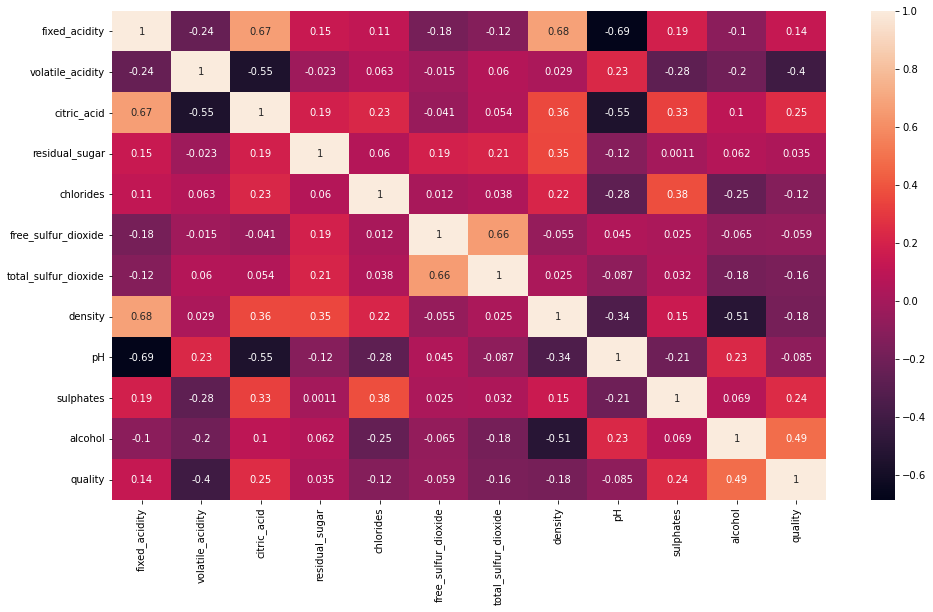

In [ ]:
plt.figure(figsize = (16,9))
sns.heatmap(df_eda.corr() , annot = True)

There are some independent variables that has relatively high correlations 
e.g. 
1. free sulfur dioxide vs total sulfur dioxide,
2. pH levels and the different acids

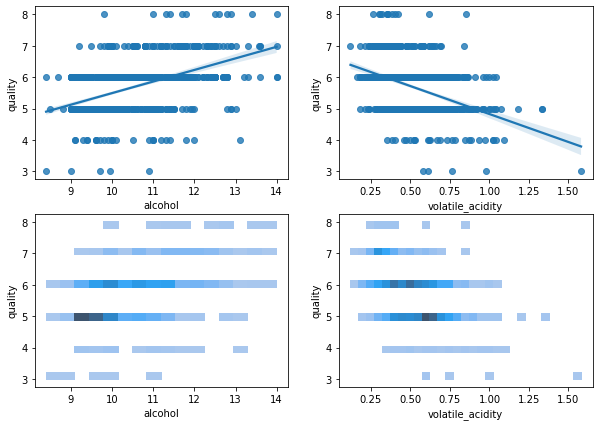

In [ ]:
plt.figure(figsize = (10,7))
plt.subplot(2,2,1)
sns.regplot(x = df_eda.alcohol , y = df_eda.quality)
plt.subplot(2,2,3)
sns.histplot(x = df_eda.alcohol , y = df_eda.quality)
plt.subplot(2,2,2)
sns.regplot(x = df_eda.volatile_acidity, y = df_eda.quality)
plt.subplot(2,2,4)
sns.histplot(x = df_eda.volatile_acidity, y = df_eda.quality)

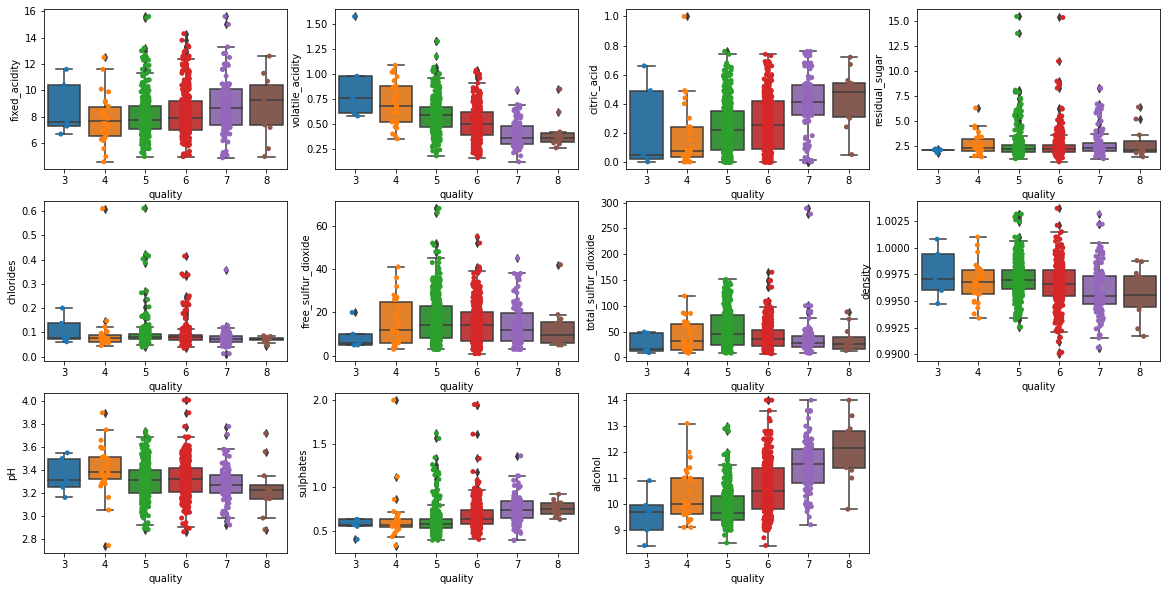

In [ ]:
plt.figure(figsize = (20,10))
for index,columns in enumerate(df_eda.drop(columns = ['quality'] , axis = 'columns').columns,1):
  plt.subplot(3,4,index)
  sns.boxplot(x = df_eda.quality , y = df_eda[f'{columns}'])
  sns.stripplot(x = df_eda.quality , y = df_eda[f'{columns}'])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
features = df_eda.drop(columns = ['quality'], axis = 'columns').columns.to_list()

In [ ]:
poly = PolynomialFeatures(2)
poly_array = poly.fit_transform(df_eda[features])

In [ ]:
df_poly = pd.DataFrame(data = poly_array , columns = poly.get_feature_names_out()).drop(columns = ['1'], axis = 'columns')

In [ ]:
df_poly['quality'] = df_eda['quality']

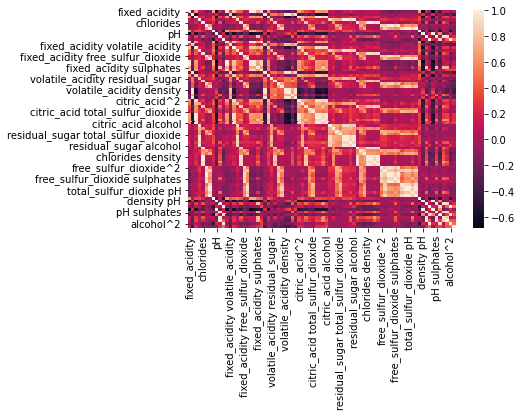

In [ ]:
sns.heatmap(df_poly.corr())

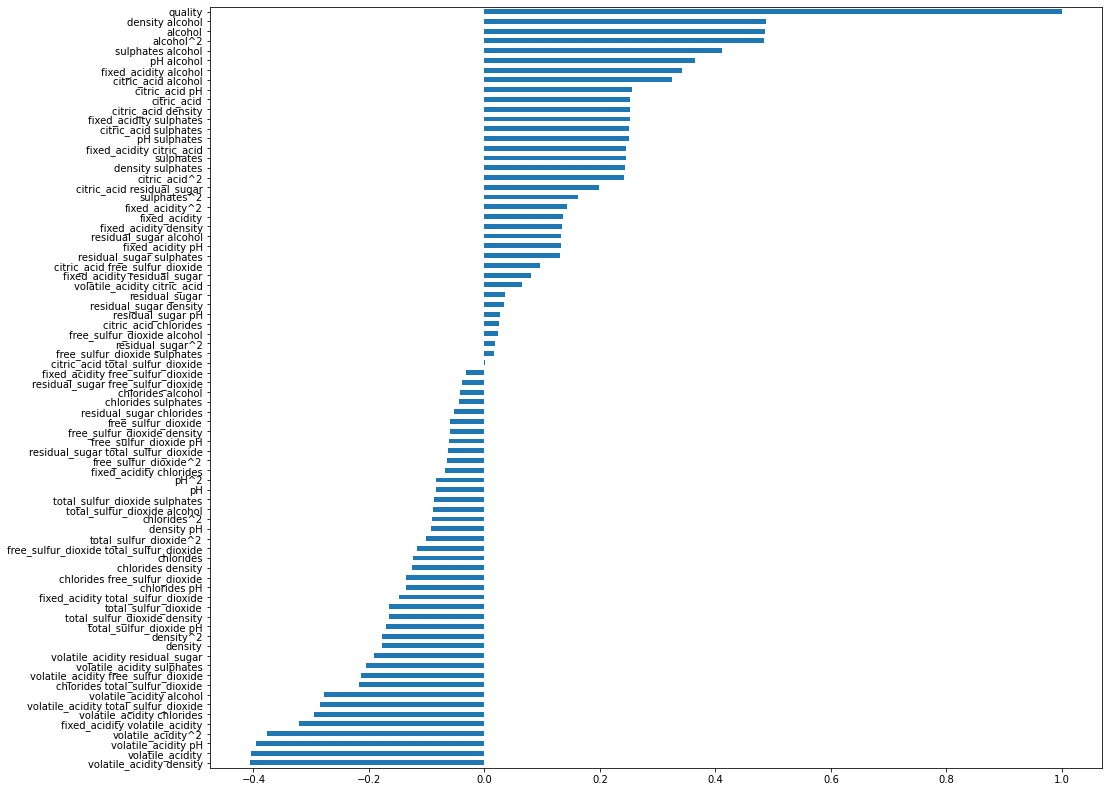

In [59]:
df_poly.corr()['quality'].sort_values().plot(kind = 'barh',figsize = (16,14))

In [62]:
ct = make_column_transformer((RobustScaler(),
                              make_column_selector(dtype_include = np.number)))

In [63]:
pipe = Pipeline([('column_transformer',ct),
                 ('polynomial_features', PolynomialFeatures()),
                 ('clf',VotingClassifier(estimators = [('lr', LogisticRegression(penalty = 'l2',solver = 'liblinear', warm_start = True, C = 0.1)),
                                                       ('rf', RandomForestClassifier(max_depth = 5))]
                                         )
                 )
                 ])

In [64]:
param_grid = {}
param_grid['clf__rf__n_estimators'] = [10,20,50,100]
param_grid['clf__lr__C'] = [0.1,0.01,0.001]
param_grid['clf__rf__max_depth'] = [3,4,5]

gs = GridSearchCV(estimator = pipe , 
                  param_grid = param_grid,
                  cv = 2)

In [65]:
gs.fit(X = X_train,
       y = y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('robustscaler',
                                                                         RobustScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f3eaa33a450>)])),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('clf',
                                        VotingClassifier(estimators=[('lr',
                                                                      LogisticRegression(class_weight='balanced',
                                                                                         max_iter=10000,
                                                                                         solver='liblinear')),


In [67]:
gs.score(X_train,y_train) , gs.score(X_val,y_val)

(0.6306569343065693, 0.6026200873362445)

In [68]:
gs.best_params_

{'clf__lr__C': 0.001, 'clf__rf__max_depth': 5, 'clf__rf__n_estimators': 20}

In [71]:
pd.DataFrame(gs.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__lr__C,param_clf__rf__max_depth,param_clf__rf__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
33,0.069366,0.000846,0.009889,0.000027,0.001,5,20,"{'clf__lr__C': 0.001, 'clf__rf__max_depth': 5,...",0.516035,0.540936,0.528485,0.012450,1
11,0.257621,0.000150,0.021230,0.000111,0.1,5,100,"{'clf__lr__C': 0.1, 'clf__rf__max_depth': 5, '...",0.518950,0.535088,0.527019,0.008069,2
6,0.147990,0.000078,0.013903,0.000013,0.1,4,50,"{'clf__lr__C': 0.1, 'clf__rf__max_depth': 4, '...",0.545190,0.508772,0.526981,0.018209,3
31,0.232927,0.010300,0.021803,0.000409,0.001,4,100,"{'clf__lr__C': 0.001, 'clf__rf__max_depth': 4,...",0.507289,0.540936,0.524112,0.016824,4
30,0.128783,0.001615,0.015048,0.000326,0.001,4,50,"{'clf__lr__C': 0.001, 'clf__rf__max_depth': 4,...",0.513120,0.532164,0.522642,0.009522,5
2,0.226204,0.008912,0.030803,0.005720,0.1,3,50,"{'clf__lr__C': 0.1, 'clf__rf__max_depth': 3, '...",0.518950,0.526316,0.522633,0.003683,6
18,0.141452,0.009141,0.014045,0.000156,0.01,4,50,"{'clf__lr__C': 0.01, 'clf__rf__max_depth': 4, ...",0.527697,0.517544,0.522620,0.005076,7
21,0.087941,0.010862,0.010122,0.000228,0.01,5,20,"{'clf__lr__C': 0.01, 'clf__rf__max_depth': 5, ...",0.542274,0.502924,0.522599,0.019675,8
29,0.068666,0.000239,0.010322,0.000289,0.001,4,20,"{'clf__lr__C': 0.001, 'clf__rf__max_depth': 4,...",0.507289,0.535088,0.521188,0.013900,9
34,0.134302,0.001065,0.014329,0.000094,0.001,5,50,"{'clf__lr__C': 0.001, 'clf__rf__max_depth': 5,...",0.498542,0.540936,0.519739,0.021197,10


In [74]:
def plot_cm(y_true,y_pred):
  cm = confusion_matrix(y_true = y_true,
                        y_pred = y_pred,normalize = 'true')
  ConfusionMatrixDisplay(cm).plot()

In [76]:
preds = gs.predict(X_val)

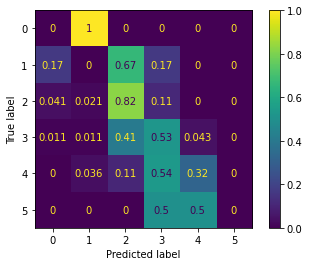

In [77]:
plot_cm(y_val,preds)

The model tend to underestimate it's quality predictions